In [41]:
from sklearn.datasets import make_moons
import logging
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR as CLR

import lightning as L

from dal_toolbox.models.ensemble import EnsembleModel
from dal_toolbox.active_learning.data import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import CoreLogBatchSampling
from dal_toolbox.utils import seed_everything


In [42]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    x_domain = 2.5
    y_domain = 1.5
    xx, yy = torch.meshgrid(torch.linspace(-x_domain, x_domain, 51), torch.linspace(-y_domain, y_domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    ens_logits = model.mc_forward(zz)
    ens_probas = ens_logits.softmax(-1)
    probas = torch.mean(ens_probas, dim=1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_u[:, 0], X_u[:, 1], c=['purple' if i == 0 else 'yellow' for i in y_u], s=35, edgecolors='black')
    plt.scatter(X_l[:, 0], X_l[:, 1], c=['purple' if i == 0 else 'yellow' for i in y_l], s=50, edgecolors='red')
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

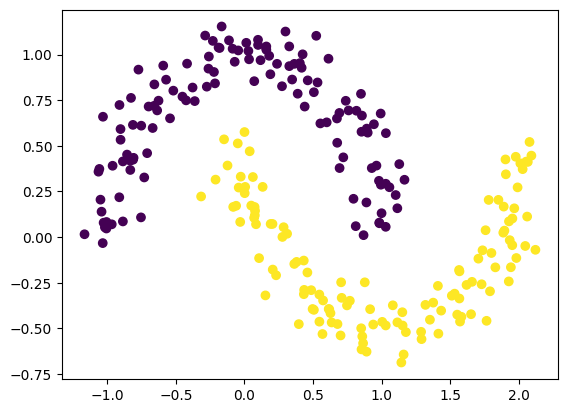

In [43]:
X, Y = make_moons(n_samples=250, noise=0.1, random_state=42)
plt.scatter(x=X[:,0], y=X[:,1], c=Y)
plt.show()
X, Y = torch.tensor(X).float(), torch.tensor(Y).long()
dataset = TensorDataset(X, Y)

In [44]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear1 = nn.Linear(2, 50)
        self.fc = nn.Linear(50, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.fc(x)
        return x

    @torch.no_grad()
    def get_logits(self, dataloader, device):
        self.to(device)
        all_logits = []
        for batch in dataloader:
            samples = batch[0]
            logits = self(samples.to(device))
            all_logits.append(logits)
        return torch.cat(all_logits)

Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | ModuleList        | 2.5 K 
1 | loss_fn       | CrossEntropyLoss  | 0     
2 | train_metrics | ModuleDict        | 0     
3 | val_metrics   | ModuleDict        | 0     
4 | val_loss_fn   | GibbsCrossEntropy | 0     
----------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      

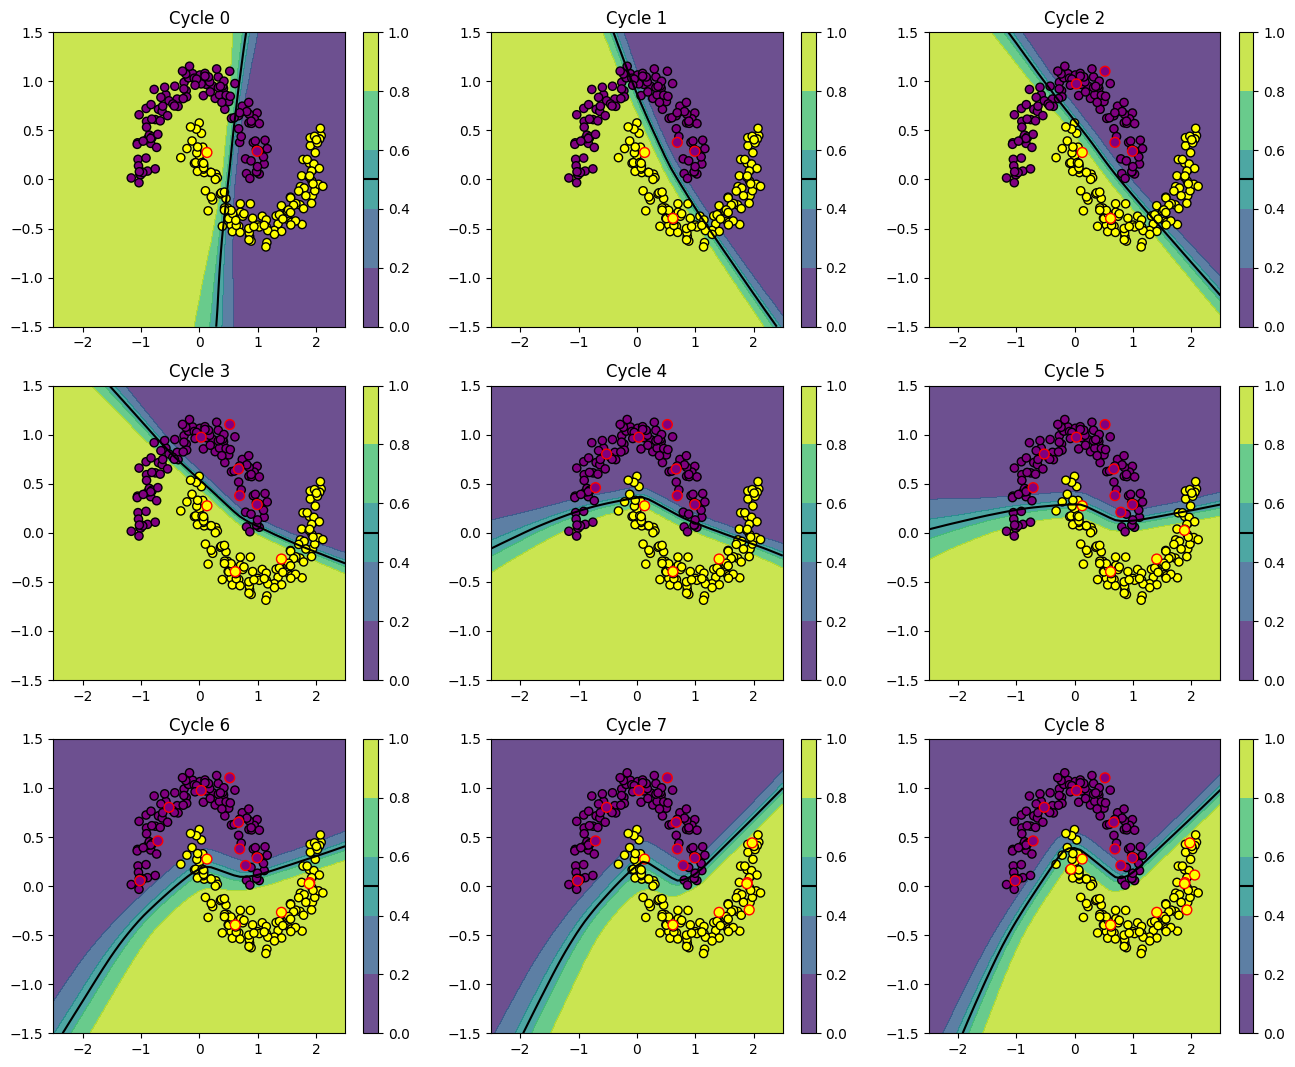

In [45]:
n_members, n_epochs, n_cycles, n_init, acq_size = 10, 50, 9, 2, 2

seed_everything(2)

al_datamodule = ActiveLearningDataModule(
    train_dataset=dataset,
    query_dataset=dataset,
    val_dataset=dataset,
    train_batch_size=8,
    predict_batch_size=8
)

al_datamodule.random_init(n_samples=n_init)

nets = [SimpleNet() for i in range(n_members)]
optimizers = [SGD(params=m.parameters(), lr=0.1, weight_decay=0.0005, nesterov=True, momentum=0.9) for m in nets]
lr_schedulers = [CLR(opt, T_max=n_epochs) for opt in optimizers]
model = EnsembleModel(
    model_list=nets,
    optimizer_list=optimizers,
    lr_scheduler_list=lr_schedulers
)

al_strategy = CoreLogBatchSampling(estimation_pool_size=1, T_fraction=1)

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(16,13))

for i_acq in range(0, n_cycles):
        logging.info('Starting AL iteration %s / %s', i_acq, n_cycles)

        # Analyse unlabeled set and query most promising data
        if i_acq != 0:
            indices = al_strategy.query(
                model=model,
                al_datamodule=al_datamodule,
                acq_size=acq_size,
            )
            al_datamodule.update_annotations(indices)

        # Train with updated annotations
        model.reset_states()
        trainer = L.Trainer(
            max_epochs=n_epochs,
            enable_progress_bar=False,
            check_val_every_n_epoch=5,
            enable_checkpointing=False,
            logger=False,
        )
        trainer.fit(model, al_datamodule)

        l_ind = al_datamodule.labeled_indices
        u_ind = al_datamodule.unlabeled_indices

        plot_contour(model, X[l_ind], Y[l_ind], X[u_ind], Y[u_ind], ax=ax[i_acq//3][i_acq%3])
        ax[i_acq//3][i_acq%3].set_title("Cycle "+str(i_acq))